Import revelant packages


In [227]:
import numpy as np
from sklearn import preprocessing
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold

Read in the data set, split into data (`x`) and labels (`y`) then scale the data


In [228]:
data = pd.read_csv("Mixcancer.csv")
y = np.asarray(data.pop('Diagnosis'))
x = np.asarray(data)

x = preprocessing.MinMaxScaler().fit_transform(x)

Split data and labels into test & train sets


In [229]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.5, random_state=0)


Softmax activation & derivative


In [230]:
def softmax(vector):
  e = np.exp(vector)
  return e / e.sum(axis = 1, keepdims=True)

def softmax_derivative(vector):
    return softmax(vector)*(1-softmax(vector))

Relu activation & derivative


In [231]:
def LReLU(x):
    return np.where(x > 0, x, x * 0.01)

def dLReLU(x):
    return np.where(x > 0, 1, 0.01)

Cross entropy & derivative


In [232]:
def crossEntrop(o,y):
    return (-y*(np.log(o)) - (1-y)* np.log(1-o))

def crossEntrDeriv(o,y):

  return -(y/o - (1-y)/(1-o))

Define layer sizes


In [233]:
layer_1_size = 5
layer_2_size = 2

Initialise weights & biases


In [234]:
np.random.seed(0)
w1 = np.random.uniform(-1,1,[x_train.shape[1],layer_1_size])
w2 = np.random.uniform(-1,1,[layer_1_size,layer_2_size])

b1 = np.zeros(layer_1_size)
b2 = np.zeros(layer_2_size)


Initialise variables for training


In [235]:
epochs = 3000
lr = 0.005
batch_size = 128

In [236]:
def format_y(y):
  out = []
  for i in range(len(y)):
    if y[i] == 0:
      out.append([0,1])
    else:
      out.append([1,0])
  return np.array(out)

Train the model


In [237]:
n = len(x_train[1])
train_E = []
test_E = []
train_Acc = []
test_Acc = []
for epoch in range(epochs):
  for i in range(0, x_train.shape[0], batch_size):
    x_batch = x_train[i:i + batch_size,:]
    y_batch = y_train[i:i + batch_size]
    y_batch = format_y(y_batch)
    if b1.shape != [layer_1_size,]:
      b1 = b1.reshape([layer_1_size,])
    if w2.shape != [layer_1_size,layer_2_size]:
      w2 = w2.reshape([layer_1_size,layer_2_size])
    in1 = x_batch@w1+b1
    out1 = LReLU(in1)
    in2 = out1@w2+b2
    out2 = softmax(in2)
    dEdO2 = crossEntrDeriv(out2,y_batch)
    dO2dIn2 = softmax_derivative(in2)
    dO1dIn1 = dLReLU(in1)
    
    dEdW2 = 1/n * out1.T@(dEdO2*dO2dIn2)
    dEdB2 = 1/n * np.ones([1,x_batch.shape[0]])@(dEdO2*dO2dIn2)
    
    w2 = w2.reshape(2,w2.shape[0])

    dEdW1 = 1/n * x_batch.T@((np.reshape(dEdO2*dO2dIn2,[len(x_batch),2])@w2)*dO1dIn1)
    dEdB1 = 1/n * np.ones([1,x_batch.shape[0]])@((np.reshape(dEdO2*dO2dIn2,[len(x_batch),2])@w2)*dO1dIn1)

    w1 -= lr*dEdW1
    w2 -= lr*dEdW2.T
    b1 -= lr*dEdB1[0,:]
    b2 -= lr*np.reshape(dEdB2,[2,])
  error_train = crossEntrop(out2,y_batch)
  b1 = b1.reshape([layer_1_size,])
  w2 = w2.reshape([layer_1_size,2])
  error_test = crossEntrop(softmax(LReLU(x_test@w1+b1)@w2+b2),format_y(y_test))

  train_E.append(error_train.mean())
  test_E.append(error_test.mean())

  predictions_train = np.round(out2)
  prediction_test = np.round(softmax(LReLU(x_test@w1+b1)@w2+b2))
  train_Acc.append(metrics.accuracy_score(y_batch,predictions_train))
  test_Acc.append(metrics.accuracy_score(format_y(y_test),prediction_test))


Plot accuracies & errors


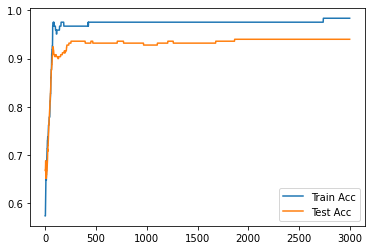

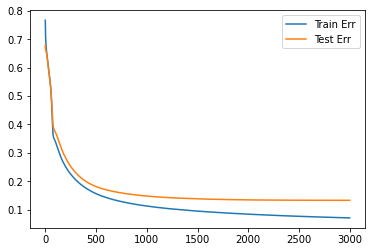

0.9836065573770492 0.94


In [238]:
plt.plot(train_Acc,label='Train Acc')
plt.plot(test_Acc,label='Test Acc')
plt.legend()
plt.show()
plt.plot(train_E,label='Train Err')
plt.plot(test_E,label='Test Err')
plt.legend()
plt.show()
print(train_Acc[-1],test_Acc[-1])